Notebook downloaded from Kaggle: https://www.kaggle.com/thomaskonstantin/bank-churn-data-exploration-and-churn-prediction/notebook

<h1 style="background-color:skyblue;font-family:newtimeroman;font-size:350%;text-align:center">Table Of Content</h1>


* [1. Introduction](#1)
    * [1.1 Libraries And Utilities](#1.1)
    * [1.2 Data Loading](#1.2)
* [2. Exploratory Data Analysis(EDA)](#2)
* [3. Data Preprocessing](#3)
    * [3.1 Data Upsampling Using SMOTE](#3.1)
    * [3.2 Principal Component Analysis Of One Hot Encoded Data](#3.2)  
* [4. Model Selection And Evaluation](#4) 
    * [4.1 Cross Validation](#4.1)
    * [4.2 Model Evaluation](#4.2)
    * [4.3 Model Evaluation On Original Data (Before Upsampling)](#4.3)
* [5. Results](#5) 


<a id="1.1"></a>
<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:200%;text-align:center">Libraries And Utilities</h3>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode()
sns.set_style('darkgrid')
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

plt.rc('figure',figsize=(18,9))
%pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Note: you may need to restart the kernel to use updated packages.


<a id="1.2"></a>
<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:200%;text-align:center">Data Loading</h3>


In [2]:
c_data = pd.read_csv('../../data/BankChurners.csv')
c_data = c_data[c_data.columns[:-2]]
c_data.head(3)

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  

[3 rows x 21 columns]

<a id="2"></a>
<h1 style="background-color:skyblue;font-family:newtimeroman;font-size:300%;text-align:center">Exploratory Data Analysis</h1>


In [3]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=c_data['Customer_Age'],name='Age Box Plot',boxmean=True)
tr2=go.Histogram(x=c_data['Customer_Age'],name='Age Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of Customer Ages")
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>We can see that the distribution of customer ages in our dataset follows a fairly normal distribution, thus further use of the age feature can be done with the normality assumption.</span></p>

In [4]:
ex.pie(c_data,names='Gender',title='Propotion Of Customer Genders')

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>There are more samples of females in our dataset compared to males but the percentage of difference is not that significant so we can say that genders are uniformly distributed.</span></p>

In [5]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=c_data['Dependent_count'],name='Dependent count Box Plot',boxmean=True)
tr2=go.Histogram(x=c_data['Dependent_count'],name='Dependent count Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of Dependent counts (close family size)")
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>The distribution of Dependent counts is fairly normally distributed with a slight right skew.</span></p>

In [6]:
ex.pie(c_data,names='Education_Level',title='Propotion Of Education Levels')

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>If assuming that most of the customers with unknown education status lack any sort of education we can state that more than 70% of the customers have a formal education level of which about 35% have a higher level of education.</span></p>

In [7]:
ex.pie(c_data,names='Marital_Status',title='Propotion Of Different Marriage Statuses')


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Almost half of the customers of the bank are married and interestingly enough almost the entire other half are customers which are single.only about 7% of the customers are divorced which is surprising considering the worldwide divorce rate statistics! (let me know where the bank is located and sign me up!)</span></p>

In [8]:
ex.pie(c_data,names='Income_Category',title='Propotion Of Different Income Levels')

In [9]:
ex.pie(c_data,names='Card_Category',title='Propotion Of Different Card Categories')

In [10]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=c_data['Months_on_book'],name='Months on book Box Plot',boxmean=True)
tr2=go.Histogram(x=c_data['Months_on_book'],name='Months on book Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of months the customer is part of the bank")
fig.show()

In [11]:
print('Kurtosis of Months on book features is : {}'.format(c_data['Months_on_book'].kurt()))

Kurtosis of Months on book features is : 0.40010012019986707


<p style="text-align: center;"><span style='font-size: 24px; font-family: "Times New Roman", Times, serif;'>We have a low kurtosis value pointing to a very flat shaped distribution (as can be seen in the plots above as well) meaning we cannot assume normality of the feature.</span></p>

In [12]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=c_data['Total_Relationship_Count'],name='Total no. of products Box Plot',boxmean=True)
tr2=go.Histogram(x=c_data['Total_Relationship_Count'],name='Total no. of products Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of Total no. of products held by the customer")
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>The distribution of the total number of products held by the customer seems to be closer to a uniform distribution and may appear useless as a predictor for churn status.</span></p>

In [13]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=c_data['Months_Inactive_12_mon'],name='number of months inactive Box Plot',boxmean=True)
tr2=go.Histogram(x=c_data['Months_Inactive_12_mon'],name='number of months inactive Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of the number of months inactive in the last 12 months")
fig.show()

In [14]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=c_data['Credit_Limit'],name='Credit_Limit Box Plot',boxmean=True)
tr2=go.Histogram(x=c_data['Credit_Limit'],name='Credit_Limit Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of the Credit Limit")
fig.show()

In [15]:
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=c_data['Total_Trans_Amt'],name='Total_Trans_Amt Box Plot',boxmean=True)
tr2=go.Histogram(x=c_data['Total_Trans_Amt'],name='Total_Trans_Amt Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of the Total Transaction Amount (Last 12 months)")
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>We see that the distribution of the total transactions (Last 12 months) displays a multimodal distribution, meaning we have some underlying groups in our data, it can be an interesting experiment to try and cluster the different groups and view the similarities between them and what describes best the different groups which create the different modes in our distribution.</span></p>

In [16]:
ex.pie(c_data,names='Attrition_Flag',title='Proportion of churn vs not churn customers')

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>As we can see only 16% of the data samples represent churn customers, in the following steps I will use SMOTE to upsample the churn samples to match them with the regular customer sample size in order to give the later selected models a better chance of catching on small details which will almost definitely be missed out with such a size difference.</span></p>

<a id="3"></a>
<h1 style="background-color:skyblue;font-family:newtimeroman;font-size:300%;text-align:center">Data Preprocessing</h1>


In [17]:
c_data.Attrition_Flag = c_data.Attrition_Flag.replace({'Attrited Customer':1,'Existing Customer':0})
c_data.Gender = c_data.Gender.replace({'F':1,'M':0})
c_data = pd.concat([c_data,pd.get_dummies(c_data['Education_Level']).drop(columns=['Unknown'])],axis=1)
c_data = pd.concat([c_data,pd.get_dummies(c_data['Income_Category']).drop(columns=['Unknown'])],axis=1)
c_data = pd.concat([c_data,pd.get_dummies(c_data['Marital_Status']).drop(columns=['Unknown'])],axis=1)
c_data = pd.concat([c_data,pd.get_dummies(c_data['Card_Category']).drop(columns=['Platinum'])],axis=1)
c_data.drop(columns = ['Education_Level','Income_Category','Marital_Status','Card_Category','CLIENTNUM'],inplace=True)

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Here we one hot encode all the categorical features describing different statuses of a customer.</span></p>

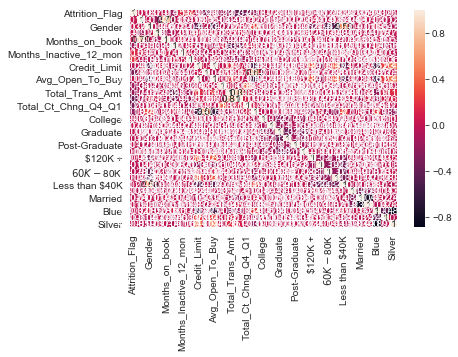

In [18]:
sns.heatmap(c_data.corr('pearson'),annot=True)

<a id="3.1"></a>
<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:200%;text-align:center">Data Upsampling Using SMOTE</h3>


In [19]:
oversample = SMOTE()
X, y = oversample.fit_resample(c_data[c_data.columns[1:]], c_data[c_data.columns[0]])
usampled_df = X.assign(Churn = y)

In [20]:
ohe_data =usampled_df[usampled_df.columns[15:-1]].copy()

usampled_df = usampled_df.drop(columns=usampled_df.columns[15:-1])

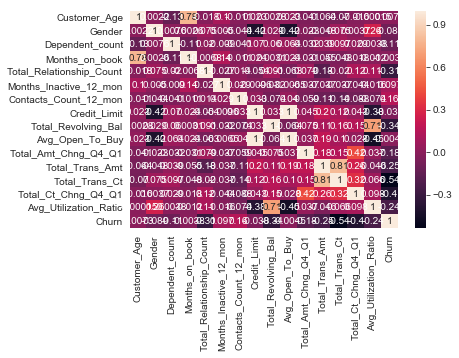

In [21]:
sns.heatmap(usampled_df.corr('pearson'),annot=True)


<a id="3.2"></a>
<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:200%;text-align:center">Principal Component Analysis Of One Hot Encoded Data </h3>


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>We will use principal component analysis to reduce the dimensionality of the one-hot encoded categorical variables losing some of the variances but at the same time using a couple of principal components instead of tens of one-hot encoded features will help me construct a better model.</span></p>

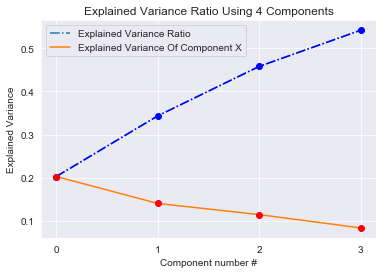

In [22]:

N_COMPONENTS = 4

pca_model = PCA(n_components = N_COMPONENTS )

pc_matrix = pca_model.fit_transform(ohe_data)

evr = pca_model.explained_variance_ratio_
cumsum_evr = np.cumsum(evr)

ax = sns.lineplot(x=np.arange(0,len(cumsum_evr)),y=cumsum_evr,label='Explained Variance Ratio')
ax.lines[0].set_linestyle('-.')
ax.set_title('Explained Variance Ratio Using {} Components'.format(N_COMPONENTS))
ax.plot(np.arange(0,len(cumsum_evr)),cumsum_evr,'bo')
ax = sns.lineplot(x=np.arange(0,len(cumsum_evr)),y=evr,label='Explained Variance Of Component X')
ax.plot(np.arange(0,len(evr)),evr,'ro')
ax.lines[1].set_linestyle('-.')
ax.set_xticks([i for i in range(0,len(cumsum_evr))])
ax.set_xlabel('Component number #')
ax.set_ylabel('Explained Variance')
plt.show()

In [23]:
usampled_df_with_pcs = pd.concat([usampled_df,pd.DataFrame(pc_matrix,columns=['PC-{}'.format(i) for i in range(0,N_COMPONENTS)])],axis=1)
usampled_df_with_pcs

Customer_Age  Gender  Dependent_count  Months_on_book  \
0                45       0                3              39   
1                49       1                5              44   
2                51       0                3              36   
3                40       1                4              34   
4                40       0                3              21   
5                44       0                2              36   
6                51       0                4              46   
7                32       0                0              27   
8                37       0                3              36   
9                48       0                2              36   
10               42       0                5              31   
11               65       0                1              54   
12               56       0                1              36   
13               35       0                3              30   
14               57       1                2              48   
15               44       0                4              37   
16               48       0                4              36   
17               41       0                3              34   
18               61       0                1              56   
19               45       1                2              37   
20               47       0                1              42   
21               62       1                0              49   
22               41       0                3              33   
23               47       1                4              36   
24               54       0                2              42   
25               41       1                3              28   
26               59       0                1              46   
27               63       0                1              56   
28               44       1                3              34   
29               47       0                4              42   
...             ...     ...              ...             ...   
16970            54       0                3              35   
16971            49       0                3              36   
16972            48       1                1              40   
16973            41       1                1              36   
16974            50       1                0              42   
16975            45       1                1              36   
16976            59       1                0              53   
16977            46       0                3              40   
16978            46       0                3              36   
16979            60       1                0              46   
16980            39       0                2              27   
16981            40       1                3              34   
16982            47       1                1              38   
16983            43       0                1              28   
16984            45       1                3              36   
16985            36       0                1              36   
16986            33       0                1              35   
16987            48       1                3              34   
16988            53       1                1              47   
16989            60       0                0              48   
16990            39       1                3              28   
16991            42       1                2              30   
16992            42       0                4              35   
16993            46       1                3              36   
16994            44       1                2              35   
16995            40       1                3              16   
16996            44       1                2              36   
16997            53       0                1              39   
16998            41       1                2              36   
16999            41       1                2              29   

       Total_Relationship_Count  Month

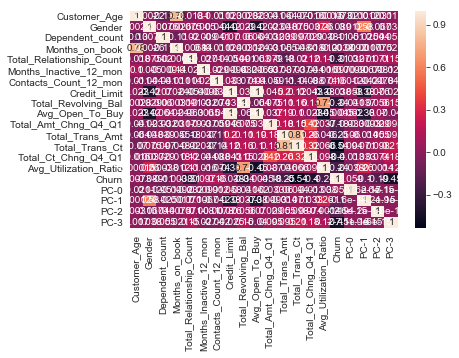

In [24]:
sns.heatmap(usampled_df_with_pcs.corr('pearson'),annot=True)


<a id="4"></a>
<h1 style="background-color:skyblue;font-family:newtimeroman;font-size:300%;text-align:center">Model Selection And Evaluation</h1>


In [25]:
X_features = ['Total_Trans_Ct','PC-3','PC-1','PC-0','PC-2','Total_Ct_Chng_Q4_Q1','Total_Relationship_Count']

X = usampled_df_with_pcs[X_features]
y = usampled_df_with_pcs['Churn']

In [26]:
train_x,test_x,train_y,test_y = train_test_split(X,y,random_state=42)

<a id="4.1"></a>
<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:200%;text-align:center">Cross Validation</h3>


In [ ]:
rf_pipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",RandomForestClassifier(random_state=42)) ])
ada_pipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",AdaBoostClassifier(random_state=42,learning_rate=0.7)) ])
svm_pipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",SVC(random_state=42,kernel='rbf')) ])


f1_cross_val_scores = cross_val_score(rf_pipe,train_x,train_y,cv=5,scoring='f1')
ada_f1_cross_val_scores=cross_val_score(ada_pipe,train_x,train_y,cv=5,scoring='f1')
svm_f1_cross_val_scores=cross_val_score(svm_pipe,train_x,train_y,cv=5,scoring='f1')

In [ ]:
plt.subplot(3,1,1)
ax = sns.lineplot(x=range(0,len(f1_cross_val_scores)),y=f1_cross_val_scores)
ax.set_title('Random Forest Cross Val Scores')
ax.set_xticks([i for i in range(0,len(f1_cross_val_scores))])
ax.set_xlabel('Fold Number')
ax.set_ylabel('F1 Score')
plt.show()
plt.subplot(3,1,2)
ax = sns.lineplot(x=range(0,len(ada_f1_cross_val_scores)),y=ada_f1_cross_val_scores)
ax.set_title('Adaboost Cross Val Scores')
ax.set_xticks([i for i in range(0,len(ada_f1_cross_val_scores))])
ax.set_xlabel('Fold Number')
ax.set_ylabel('F1 Score')
plt.show()
plt.subplot(3,1,3)
ax = sns.lineplot(x=range(0,len(svm_f1_cross_val_scores)),y=svm_f1_cross_val_scores)
ax.set_title('SVM Cross Val Scores')
ax.set_xticks([i for i in range(0,len(svm_f1_cross_val_scores))])
ax.set_xlabel('Fold Number')
ax.set_ylabel('F1 Score')
plt.show()

<a id="4.2"></a>
<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:200%;text-align:center">Model Evaluation</h3>


In [ ]:
rf_pipe.fit(train_x,train_y)
rf_prediction = rf_pipe.predict(test_x)

ada_pipe.fit(train_x,train_y)
ada_prediction = ada_pipe.predict(test_x)

svm_pipe.fit(train_x,train_y)
svm_prediction = svm_pipe.predict(test_x)

print('F1 Score of Random Forest Model On Test Set - {}'.format(f1(rf_prediction,test_y)))
print('F1 Score of AdaBoost Model On Test Set - {}'.format(f1(ada_prediction,test_y)))
print('F1 Score of SVM Model On Test Set - {}'.format(f1(svm_prediction,test_y)))

<a id="4.3"></a>
<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:200%;text-align:center">Model Evaluation On Original Data (Before Upsampling)</h3>


In [ ]:
ohe_data =c_data[c_data.columns[16:]].copy()
pc_matrix = pca_model.fit_transform(ohe_data)
original_df_with_pcs = pd.concat([c_data,pd.DataFrame(pc_matrix,columns=['PC-{}'.format(i) for i in range(0,N_COMPONENTS)])],axis=1)

unsampled_data_prediction_RF = rf_pipe.predict(original_df_with_pcs[X_features])
unsampled_data_prediction_ADA = ada_pipe.predict(original_df_with_pcs[X_features])
unsampled_data_prediction_SVM = svm_pipe.predict(original_df_with_pcs[X_features])

In [ ]:
print('F1 Score of Random Forest Model On Original Data (Before Upsampling) - {}'.format(f1(unsampled_data_prediction_RF,original_df_with_pcs['Attrition_Flag'])))
print('F1 Score of AdaBoost Model On Original Data (Before Upsampling) - {}'.format(f1(unsampled_data_prediction_ADA,original_df_with_pcs['Attrition_Flag'])))
print('F1 Score of SVM Model On Original Data (Before Upsampling) - {}'.format(f1(unsampled_data_prediction_SVM,original_df_with_pcs['Attrition_Flag'])))

<a id="5"></a>
<h1 style="background-color:skyblue;font-family:newtimeroman;font-size:300%;text-align:center">Results</h1>


In [ ]:
ax = sns.heatmap(confusion_matrix(unsampled_data_prediction_RF,original_df_with_pcs['Attrition_Flag']),annot=True,cmap='coolwarm',fmt='d')
ax.set_title('Prediction On Original Data With Random Forest Model Confusion Matrix')
ax.set_xticklabels(['Not Churn','Churn'],fontsize=18)
ax.set_yticklabels(['Predicted Not Churn','Predicted Churn'],fontsize=18)

plt.show()

In [ ]:
unsampled_data_prediction_RF = rf_pipe.predict_proba(original_df_with_pcs[X_features])
skplt.metrics.plot_precision_recall(original_df_with_pcs['Attrition_Flag'], unsampled_data_prediction_RF)